In [1]:
# general
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt 


import src.clustering_old as cls
import src.filtering2 as filter2
import src.general as gn
import src.als_model_prep as prep





In [2]:
# personality scores
data1 = pd.read_excel('data/pers_scores_1098.xlsx')
# articles by some traveler
#data2 = pd.read_excel('data/articles_159.xlsx')
# traveler profile
data3 = pd.read_excel('data/users_full_7034.xlsx')
# traveler and reviews
data4 = pd.read_excel('data/reviews_32618_for_1098_users_with_location.xlsx')

In [3]:
data1.head()

,username,open,cons,extra,agree,neuro
0,007solotraveler,0.63272,0.55666,0.56360,0.58108,0.45881
1,0BKI0,0.64006,0.55189,0.56220,0.57943,0.46188
2,10179k79,0.66435,0.56099,0.56880,0.58187,0.45011
3,124_10,0.66003,0.57005,0.57221,0.59019,0.44860
4,12ReasonsWhy,0.65036,0.55429,0.56510,0.58271,0.45919


In [349]:
u_filtered = filter2.filter_user(data3)
r_filtered = filter2.filter_review(data4)
merge_filtered = filter2.merge_review_and_user(u_filtered, r_filtered)
merge_filtered = filter2.foreign_review_filter(merge_filtered)
pop_city_lst = filter2.popular_city_list(merge_filtered)
final_df = filter2.filter_final(merge_filtered, pop_city_lst)


# # prep df for spark rdd
als_temp_df = prep.prep_als_df(final_df)
user_temp = prep.unique_user_id(als_temp_df)
city_temp = prep.unique_city_id(als_temp_df)
# # with username, cityname, rating, user_id, city_id
result_df = prep.merging_unique_user_city(als_temp_df, user_temp, city_temp)


# user-feature matrix

feature_temp_0 = filter2.user_feature_filter(final_df)
feature_temp = filter2.travel_style(feature_temp_0)
style_df = filter2.travel_matrix(feature_temp)
feature_temp_1 = filter2.age_gender_dummie(feature_temp_0)
invert_feature = filter2.combine_all_dummies(feature_temp_1, style_df)


als_temp_df = prep.prep_als_df(final_df)
util_matrix = prep.utility_matrix(result_df)

# clustering 
cluster_input_df = filter2.cluster_prep_filter(final_df)
df_title_comb = filter2.grouping_city_title(cluster_input_df)
df_text_comb = filter2.grouping_city_text(cluster_input_df)
cluster_final = filter2.merging_content(df_title_comb, df_text_comb)




/Users/kammy/Desktop/galvanize/travel-time-rec/src/filtering2.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_filtered = user_df[one_thou_pt][~null_age][~null_gender][~null_style]
/Users/kammy/Desktop/galvanize/travel-time-rec/src/filtering2.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_df = merged_df[~span_mask1][~span_mask2][~span_mask3][~non_city_mask][~non_relevant_mask]


In [5]:
clust_mask = cluster_final.index == 'Yellowstone National Park'

In [6]:
cluster_final2 = cluster_final[~clust_mask]

In [7]:
reviews =  cluster_final2.text
content = [i for i in reviews]

In [23]:
merge_filtered.head()

,id,username,type,title,text,rating,taObjectCity,ageRange,gender,travelStyle
0,103,14beacon,Attractions,Better than expected,"Went with my wife, parents, two kids (7) & (12...",5,Charleston,35-49,male,"Foodie, Trendsetter, Like a Local, Luxury Trav..."
1,104,14beacon,Attractions,Solid Park - Good Bang for the Buck,My family and I just came back from spending a...,4,Farmingdale,35-49,male,"Foodie, Trendsetter, Like a Local, Luxury Trav..."
2,362,19Cam,Attractions,See it before its gone,The box is only a temporary exhibit while cons...,4,Berlin,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
3,363,19Cam,Attractions,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,Berlin,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
4,378,19Cam,Attractions,Fantastic,"After reading all the hype about this show, I ...",5,London,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."


In [32]:
val_lst = [i for i in Counter(merge_filtered.taObjectCity).values()]

In [25]:
merge_filtered.shape

(2591, 10)

In [24]:
als_temp_df.head()

,username,taObjectCity,rating
4,19Cam,London,5
5,19Cam,Kuala Lumpur,4
32,1oldseagull,St. Petersburg,5
40,2093,London,4
41,2093,London,4


In [9]:
city_temp.shape
# 35 cities

(34, 2)

In [10]:
city_temp.head(35)

,city_id,taObjectCity
0,0,London
1,1,Kuala Lumpur
2,2,St. Petersburg
3,3,Barcelona
4,4,Madrid
5,5,Washington DC
6,6,New York City
7,7,Budapest
8,8,Sydney
9,9,Rome


In [47]:
user_temp.shape
#(193 users when >= 12

(192, 2)

In [49]:
with_per_selected = pd.merge(data1, user_temp, on = 'username')

In [50]:
with_per_selected

,username,open,cons,extra,agree,neuro,user_id
0,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,0
1,1oldseagull,0.64249,0.56435,0.56671,0.58414,0.45906,1
2,2093,0.65093,0.56162,0.56747,0.58341,0.45337,2
3,23stationroad,0.64325,0.55728,0.56427,0.57839,0.45925,3
4,29grapes,0.65625,0.56176,0.56698,0.58058,0.45470,4
5,2toots,0.64606,0.56533,0.56923,0.59024,0.45483,5
6,422,0.64272,0.55374,0.56611,0.58561,0.46018,6
7,4bigdogsCalgary,0.64484,0.55967,0.56650,0.58313,0.45750,7
8,6079max,0.64525,0.55715,0.56473,0.57977,0.45966,8
9,678855,0.63959,0.55731,0.56596,0.58653,0.46215,9


In [46]:
user_temp.shape
#(193 users when >= 12

(192, 2)

In [12]:
Counter(result_df.taObjectCity).keys()

dict_keys(['London', 'Kuala Lumpur', 'St. Petersburg', 'Barcelona', 'Madrid', 'Washington DC', 'New York City', 'Budapest', 'Sydney', 'Rome', 'Nashville', 'San Francisco', 'Dubai', 'Chicago', 'Orlando', 'Anaheim', 'Amsterdam', 'Honolulu', 'Paris', 'Las Vegas', 'Boston', 'Bangkok', 'Hong Kong', 'Munich', 'Singapore', 'Venice', 'Los Angeles', 'Edinburgh', 'Istanbul', 'Oslo', 'Toronto', 'Moscow', 'New Orleans', 'San Diego'])

# new cluster function
## chanllenge: create reasonable clusters

In [13]:
reviews;

In [14]:
vector, cols = cls.cluster_texts(content)
cluster_df = cls.cluster(vector, cols, reviews)

0
['bar', 'view', 'bit', 'bay', 'night', 'years', 'going', 'enjoy', 'drinks', 'amazing', 'hotel', 'want', 'ride', 'views', 'know', 'table', 'need', 'lake', 'service', 'tourists']
1
['history', 'guide', 'building', 'walk', 'city', 'park', 'hours', 'enjoyed', 'tickets', 'view', 'took', 'lovely', 'world', 'excellent', 'recommend', 'little', 'bus', 'look', 'huge', 'tours']
2
['park', 'universal', 'parking', 'rides', 'cars', 'fireworks', 'ride', 'love', 'movie', 'center', 'definitely', 'kids', 'attractions', 'pass', 'old', 'friendly', 'small', 'best', 'fast', 'quite']
3
['memorial', 'beach', 'war', 'views', 'water', 'morning', 'floor', '30', 'exhibit', 'happy', 'history', 'especially', 'stairs', 'harbour', 'boat', 'saturday', 'make', 'store', 'night', 'guide']


In [15]:
mask4 = cluster_df.cluster_k == 4
mask3 = cluster_df.cluster_k == 3
mask2 = cluster_df.cluster_k == 2
mask1 = cluster_df.cluster_k == 1
mask0 = cluster_df.cluster_k == 0

In [16]:
cluster_df;

In [17]:
cluster_df[mask0]

,cluster_k,city_index
2,0,Bangkok
4,0,Boston
6,0,Chicago
7,0,Dubai
9,0,Hong Kong
13,0,Las Vegas
16,0,Madrid
20,0,New Orleans
26,0,San Diego
27,0,San Francisco


In [18]:
cluster_df[mask1]

,cluster_k,city_index
0,1,Amsterdam
3,1,Barcelona
5,1,Budapest
8,1,Edinburgh
11,1,Istanbul
12,1,Kuala Lumpur
14,1,London
17,1,Moscow
19,1,Nashville
21,1,New York City


In [19]:
cluster_df[mask2]

,cluster_k,city_index
1,2,Anaheim
15,2,Los Angeles
18,2,Munich
22,2,Orlando


In [20]:
cluster_df[mask3]

,cluster_k,city_index
10,3,Honolulu
33,3,Washington DC


In [21]:
cluster_df[mask4]

,cluster_k,city_index


In [22]:
plt.hist(arr, bins=20, range=[0, 10]);

NameError: name 'arr' is not defined

In [51]:
arr = np.array([i for i in Counter(merge_filtered.taObjectCity).values()])

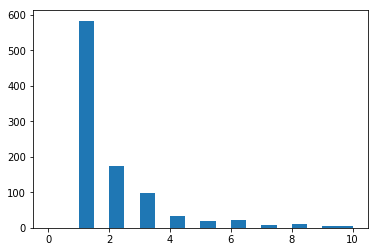

In [52]:
plt.hist(arr, bins=20, range=[0, 10]);

In [53]:
style_df.Foodie.sum()/style_df.shape[0]

0.5

In [54]:
style_df['Like a Local'].sum()/style_df.shape[0]

0.4479166666666667

In [55]:
style_df['History Buff'].sum()/style_df.shape[0]

0.34375

In [56]:
style_df['Urban Explorer'].sum()/style_df.shape[0]

0.3489583333333333

In [57]:
user_temp.head()

,user_id,username
0,0,19Cam
1,1,1oldseagull
2,2,2093
3,3,23stationroad
4,4,29grapes


In [58]:
result_df.shape

(764, 5)

In [59]:
feature_temp_1.head()

,username,travelStyle,new_travel,ageRange_25-34,ageRange_35-49,ageRange_50-64,ageRange_65+,gender_female,gender_male
4,19Cam,"Vegetarian, Urban Explorer, Art and Architectu...","[Vegetarian, Urban Explorer, Art and Architect...",1,0,0,0,0,1
32,1oldseagull,"Foodie, Beach Goer, History Buff, 60+ Traveler...","[Foodie, Beach Goer, History Buff, 60+ Travele...",0,0,0,1,0,1
40,2093,"Like a Local, History Buff, Urban Explorer","[Like a Local, History Buff, Urban Explorer]",0,1,0,0,1,0
83,23stationroad,"Foodie, Like a Local, Thrifty Traveller","[Foodie, Like a Local, Thrifty Traveller]",0,0,1,0,1,0
88,29grapes,"Foodie, 60+ Traveler, Like a Local, Nature Lov...","[Foodie, 60+ Traveler, Like a Local, Nature Lo...",0,0,0,1,0,1


In [341]:
invert_feature.columns

Index(['ageRange_25-34', 'ageRange_35-49', 'ageRange_50-64', 'ageRange_65+',
       'gender_female', 'Art and Architecture Lover', 'Backpacker',
       'Beach Goer', 'Eco-tourist', 'Family Hoilday Maker', 'Foodie',
       'History Buff', 'Like a Local', 'Luxury Traveller', 'Nature Lover',
       'Nightlife Seeker', 'Peace and Quiet Seeker', 'Shopping Fanatic',
       'Thrifty Traveller', 'Thrill Seeker', 'Trendsetter', 'Urban Explorer',
       'Vegetarian'],
      dtype='object')

In [306]:
invert_feature.shape

(192, 23)

In [61]:
temp_series = invert_feature[invert_feature['Foodie'] == 1].T.sum()
mask = temp_series[:] == 2
mask

1      False
3      False
4      False
5      False
7      False
8      False
9      False
10     False
18     False
19     False
20     False
27     False
28     False
29     False
31     False
32     False
35     False
36     False
40     False
42     False
43     False
44     False
46     False
47     False
54     False
56     False
57     False
58     False
60     False
64     False
       ...  
141    False
142     True
143    False
144    False
145    False
146    False
147    False
150    False
151    False
152    False
153    False
154    False
158    False
159    False
160    False
161    False
165    False
169    False
170    False
171    False
173    False
175    False
177    False
178    False
179    False
182    False
184    False
185    False
187    False
189    False
Length: 96, dtype: bool

In [62]:
temp_series[mask]

77     2
134    2
142    2
dtype: int64

In [66]:
invert_feature.iloc[142]

ageRange_25-34                0
ageRange_35-49                1
ageRange_50-64                0
ageRange_65+                  0
gender_female                 0
Art and Architecture Lover    0
Backpacker                    0
Beach Goer                    0
Eco-tourist                   0
Family Hoilday Maker          0
Foodie                        1
History Buff                  0
Like a Local                  0
Luxury Traveller              0
Nature Lover                  0
Nightlife Seeker              0
Peace and Quiet Seeker        0
Shopping Fanatic              0
Thrifty Traveller             0
Thrill Seeker                 0
Trendsetter                   0
Urban Explorer                0
Vegetarian                    0
Name: 142, dtype: uint8

In [108]:
invert_feature.shape

(192, 23)

In [109]:
invert_feature.head()

,ageRange_25-34,ageRange_35-49,ageRange_50-64,ageRange_65+,gender_female,Art and Architecture Lover,Backpacker,Beach Goer,Eco-tourist,Family Hoilday Maker,...,Luxury Traveller,Nature Lover,Nightlife Seeker,Peace and Quiet Seeker,Shopping Fanatic,Thrifty Traveller,Thrill Seeker,Trendsetter,Urban Explorer,Vegetarian
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,1,0,1,1,0,0,0,1,0


In [318]:
#invert_feature['Vegetarian'] + invert_feature['Eco-tourist']

In [350]:
def veg_or_eco(df):
    
    veg_or_eco_lst = [item-1 if item == 2 else item for item in df['Vegetarian'] + df['Eco-tourist']]
    #print (veg_or_eco_lst)
    df['veg_or_eco'] = veg_or_eco_lst
    #print(df['veg_or_eco'])
    #df['veg_or_eco'] = [item-1 if item == 2 for item in df['veg_or_eco'] 
    
    return df
        

In [351]:
new_invert_feature = veg_or_eco(invert_feature)

In [353]:
new_invert_feature.veg_or_eco.unique()

array([1, 0])

In [ ]:
style_df.head()

In [ ]:
invert_feature.head()

In [67]:
user_temp[user_temp.user_id == 77]
#user_temp[user_temp.user_id == 144]

,user_id,username
77,77,BobbyGAus


In [ ]:
data4[(data4.username == 'DC20something') & (data4.type == 'Attractions')]

In [68]:
data4[(data4.username == 'BobbyGAus') & (data4.type == 'Attractions')]

,id,username,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
15011,15028,BobbyGAus,Attractions,2014-12-30,40 Minutes of Relaxtion,Take a trip on this little boat and see the Ri...,5,1.0,101,Popeye Motor Launches,http://www.tripadvisor.com/Attraction_Review-g...,Adelaide
15012,15029,BobbyGAus,Attractions,2014-12-30,Pandas In Oz,We saw Pandas without leaving our shores!\nThe...,5,2.0,102,Adelaide Zoo,http://www.tripadvisor.com/Attraction_Review-g...,Adelaide
15013,15030,BobbyGAus,Attractions,2014-12-30,Zooms Along,A must do trip to Glenelg/Brighton is enhances...,5,1.0,101,Glenelg Tram,http://www.tripadvisor.com/Attraction_Review-g...,Adelaide
15015,15032,BobbyGAus,Attractions,2014-10-22,My First Warship,The main attraction is the former HMAS Diamant...,5,0.0,100,Queensland Maritime Museum,http://www.tripadvisor.com/Attraction_Review-g...,Brisbane
15019,15036,BobbyGAus,Attractions,2014-08-04,Italian Masters,"I am not an ""art lover"" as such but gee those ...",5,0.0,100,National Gallery of Victoria,http://www.tripadvisor.com/Attraction_Review-g...,Melbourne
15024,15041,BobbyGAus,Attractions,2014-02-01,BIG Day Out,As the title suggests it is a big (and long) d...,5,1.0,101,Bunyip Tours - Day Tours,http://www.tripadvisor.com/Attraction_Review-g...,Melbourne
15026,15043,BobbyGAus,Attractions,2014-02-01,Breathtaking,We took a tour bus (see seperate review) to se...,5,1.0,101,The Great Ocean Road,http://www.tripadvisor.com/Attraction_Review-g...,Torquay
15036,15053,BobbyGAus,Attractions,2013-01-26,Great Value Day Out,"Although we have seen many ""water"" attractions...",5,0.0,100,Underwater World Sea Life Mooloolaba,http://www.tripadvisor.com/Attraction_Review-g...,Mooloolaba
15037,15054,BobbyGAus,Attractions,2013-01-26,Professional,This is a MUST SEE at the Sunshine Coast.\nThe...,5,0.0,100,Australia Zoo,http://www.tripadvisor.com/Attraction_Review-g...,Beerwah
15044,15061,BobbyGAus,Attractions,2012-09-26,The Showboat,"Fantastic show, great food and a good choice o...",5,1.0,101,Magistic Cruises,http://www.tripadvisor.com/Attraction_Review-g...,Sydney


In [ ]:
invert_feature.drop([''])

In [ ]:
final_df.shape

In [ ]:
user_temp.shape

In [ ]:
with_personality = pd.merge(user_temp, data1, on = 'username')

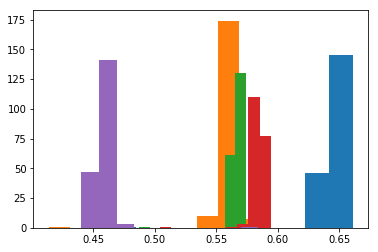

In [72]:
plt.hist(with_per_selected.open);
plt.hist(with_per_selected.cons);
plt.hist(with_per_selected.extra);
plt.hist(with_per_selected.agree);
plt.hist(with_per_selected.neuro);

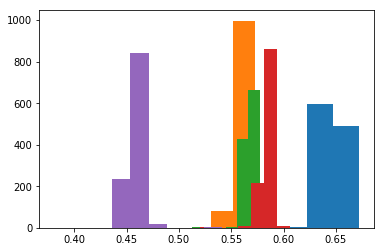

In [73]:
plt.hist(data1.open);
plt.hist(data1.cons);
plt.hist(data1.extra);
plt.hist(data1.agree);
plt.hist(data1.neuro);

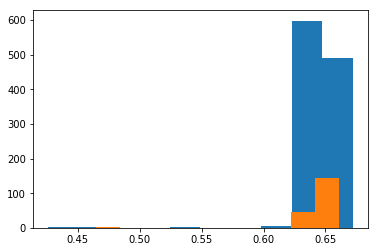

In [75]:
plt.hist(data1.open);
plt.hist(with_per_selected.open);

# People who are high on the openness continuum are typically:

* Very creative
* Open to trying new things
* Focused on tackling new challenges
* Happy to think about abstract concepts

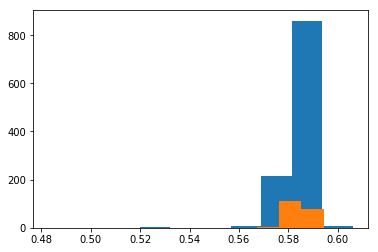

In [76]:
plt.hist(data1.agree);
plt.hist(with_per_selected.agree);

In [71]:
data1.agree.describe()

count    1098.000000
mean        0.584330
std         0.006693
min         0.482840
25%         0.582013
50%         0.585040
75%         0.587765
max         0.606020
Name: agree, dtype: float64

In [70]:
with_per_selected.agree.describe()

count    192.000000
mean       0.583414
std        0.007071
min        0.504040
25%        0.581330
50%        0.584015
75%        0.586435
max        0.594260
Name: agree, dtype: float64

# Agreeableness


* Have a great deal of interest in other people
* Care about others
* Feel empathy and concern for other people
* Enjoy helping and contributing to the happiness of other people

In [77]:
with_per_selected.head()

,username,open,cons,extra,agree,neuro,user_id
0,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,0
1,1oldseagull,0.64249,0.56435,0.56671,0.58414,0.45906,1
2,2093,0.65093,0.56162,0.56747,0.58341,0.45337,2
3,23stationroad,0.64325,0.55728,0.56427,0.57839,0.45925,3
4,29grapes,0.65625,0.56176,0.56698,0.58058,0.45470,4


In [92]:
with_per_selected.describe()

,open,cons,extra,agree,neuro,user_id
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,0.645117,0.558765,0.566096,0.583414,0.458339,95.500000
std,0.014600,0.011803,0.006231,0.007071,0.010430,55.569776
min,0.464870,0.413670,0.487600,0.504040,0.440280,0.000000
25%,0.641675,0.556407,0.564803,0.581330,0.454695,47.750000
50%,0.646215,0.558945,0.566495,0.584015,0.457890,95.500000
75%,0.650185,0.561995,0.568095,0.586435,0.460753,143.250000
max,0.661090,0.585990,0.574060,0.594260,0.584220,191.000000


In [100]:
from pandas.plotting import scatter_matrix

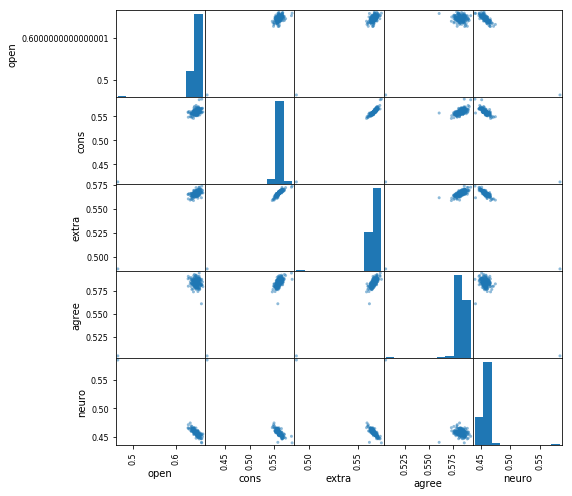

In [107]:
scatter_matrix(with_per_selected.drop(['user_id'], axis =1 ), figsize=(8, 8));



# high cons -> high extra
# high cons -> high agrees
# low neuro -> high extra, cons, open

In [149]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_similarity_score

In [287]:
only_per_df = with_per_selected.drop(['username', 'user_id'], axis=1 )

In [151]:
only_per_df.head()

,open,cons,extra,agree,neuro
0,0.64198,0.55524,0.56619,0.58622,0.46087
1,0.64249,0.56435,0.56671,0.58414,0.45906
2,0.65093,0.56162,0.56747,0.58341,0.45337
3,0.64325,0.55728,0.56427,0.57839,0.45925
4,0.65625,0.56176,0.56698,0.58058,0.45470


In [248]:
#for i in only_per_df.open

In [269]:
#only_per_df.iloc[:,1]

In [ ]:
open_arr = with_per_selected.open
open_per = np.percentile(open_arr, 50)
open_per

In [288]:
def mapping_personality(df):
    
    for i in range(len((df.columns))):
        #print(df.iloc[:, i])
        percentile = np.percentile(df.iloc[:, i], 50)
        
        
        new_items = [1 if item > percentile else 0 for item in df.iloc[:, i]]

        df[str(i)]= new_items
        
    return df
       
        
        
    

In [289]:
mapped_df = mapping_personality(only_per_df)

In [290]:
mapped_df.head()

,open,cons,extra,agree,neuro,0,1,2,3,4
0,0.64198,0.55524,0.56619,0.58622,0.46087,0,0,0,1,1
1,0.64249,0.56435,0.56671,0.58414,0.45906,0,1,1,1,1
2,0.65093,0.56162,0.56747,0.58341,0.45337,1,1,1,0,0
3,0.64325,0.55728,0.56427,0.57839,0.45925,0,0,0,0,1
4,0.65625,0.56176,0.56698,0.58058,0.45470,1,1,1,0,0


In [292]:
mapped_df = mapped_df.drop(['open', 'cons', 'extra', 'agree','neuro'], axis=1)

In [293]:
mapped_df.columns = ['open', 'cons', 'extra', 'agree','neuro']

In [295]:
mapped_df.head()

,open,cons,extra,agree,neuro
0,0,0,0,1,1
1,0,1,1,1,1
2,1,1,1,0,0
3,0,0,0,0,1
4,1,1,1,0,0


In [303]:
user1 = mapped_df.loc[2].values.reshape(5,1)
user2 = mapped_df.loc[10].values.reshape(5,1)

In [354]:
consine_sim = jaccard_similarity_score(user1, user2)

In [355]:
consine_sim

0.2

In [146]:
cosine_similarity([[-1, 0, -1]], [[-1, -1, 0]])

array([[0.5]])

In [ ]:
jaccard

In [91]:
# high open, high extra, low con
with_per_selected[(with_per_selected.open >= 0.650185) & (with_per_selected.extra >= 0.568095)].count()

username    24
open        24
cons        24
extra       24
agree       24
neuro       24
user_id     24
dtype: int64

In [89]:
# high neuro, low extra, low con
with_per_selected[(with_per_selected.neuro >= 0.460482) & (with_per_selected.extra <= 0.564803) & \
                  (with_per_selected.cons <= 0.558945)]

,username,open,cons,extra,agree,neuro,user_id
13,ALiEN2108,0.63493,0.55508,0.56383,0.58325,0.46626,13
15,AV_Surrey,0.63575,0.54729,0.56017,0.57642,0.46879,15
16,AdrianandLoretta,0.64055,0.55777,0.56361,0.58150,0.46190,16
23,Alfanumeric,0.64278,0.55840,0.56456,0.58283,0.46163,23
24,AliDUk,0.64297,0.55646,0.56473,0.58329,0.46175,24
27,Amber9,0.64513,0.55335,0.56286,0.58356,0.46612,27
34,Antoinette78,0.63520,0.55589,0.56269,0.58270,0.46461,34
47,BabsLimerick_Ireland,0.63190,0.54935,0.55942,0.58245,0.47485,47
60,BergenRoy,0.63713,0.55817,0.56478,0.58527,0.46437,60
63,Beverley29,0.64994,0.55408,0.56330,0.57679,0.46080,63


In [99]:
# high con
with_per_selected[(with_per_selected.cons >= 0.561995) & (with_per_selected.open >= 0.650185)].count()

username    26
open        26
cons        26
extra       26
agree       26
neuro       26
user_id     26
dtype: int64

In [ ]:
with_personality.loc[30]

In [ ]:
with_personality.loc[183]

In [ ]:
plt.hist(with_personality.open);

In [ ]:
sns.heatmap

In [ ]:
sns.